# Computational Social Science Project #2 

*Group number:* 2

*Group members:* Steven Herrera Tenorio, Flavia Leite, Abiola Oyebanjo

*Semester:* Fall 2022


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [41]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [42]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 

In [43]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [44]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [45]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [46]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 

['No Data']


In [47]:
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 

['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [48]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)


We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [49]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [50]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [51]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1']

In [52]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames, axis=1) 

## 2. Exploratory Data Analysis

### Race (Steven)

Our analysis of the race-related variables focus on two questions: (1) Should we assess the variables associated with two or more race-related categories? (2) With multicollinearity in mind, should we remove any of the single-race categories, assuming that question 1 satisfies the need to only assess single-race categories?

#### Single-Race Categories

Text(0, 0.5, 'Number of Respondents')

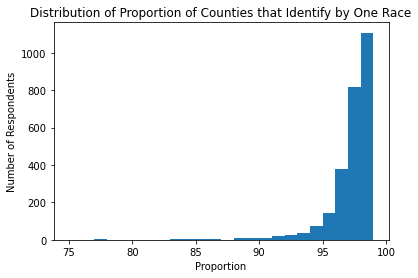

In [53]:
race_hist = diabetes['race_total population_one race'].apply(lambda x: x*100)
plt.title('Distribution of Proportion of Counties that Identify by One Race')
plt.xlabel('Proportion')
plt.hist(race_hist, bins = range(75, 100, 1));
plt.ylabel('Number of Respondents')

The first question we decided to ask: do most people identify as one race in general? Knowing this would allow us to determine whether we should assess the other variables of racial categories that assess people that identify with two or more caegories. The graph above suggests that most counties have a relatively large proportion of people that identify with one race, hence we only focus on these groups.

#### Between the Race Categories

In [54]:
race_data = diabetes[['race_total population_one race_white',
         'race_total population_one race_black or african american',
         'race_total population_one race_american indian and alaska native',
         'race_total population_one race_asian',
         'hispanic or latino and race_total population_hispanic or latino (of any race)',
         'race_total population_one race_some other race',
         'Diabetes_Number']].rename(columns = {'race_total population_one race_white': 'White',
                                              'race_total population_one race_black or african american': 'Black',
                                              'race_total population_one race_american indian and alaska native': 'Native',
                                              'race_total population_one race_asian': 'Asian',
                                               'hispanic or latino and race_total population_hispanic or latino (of any race)': 'Hispanic/Latinx',
                                              'race_total population_one race_some other race': 'Other',
                                              'Diabetes_Number': 'Diabetes'})

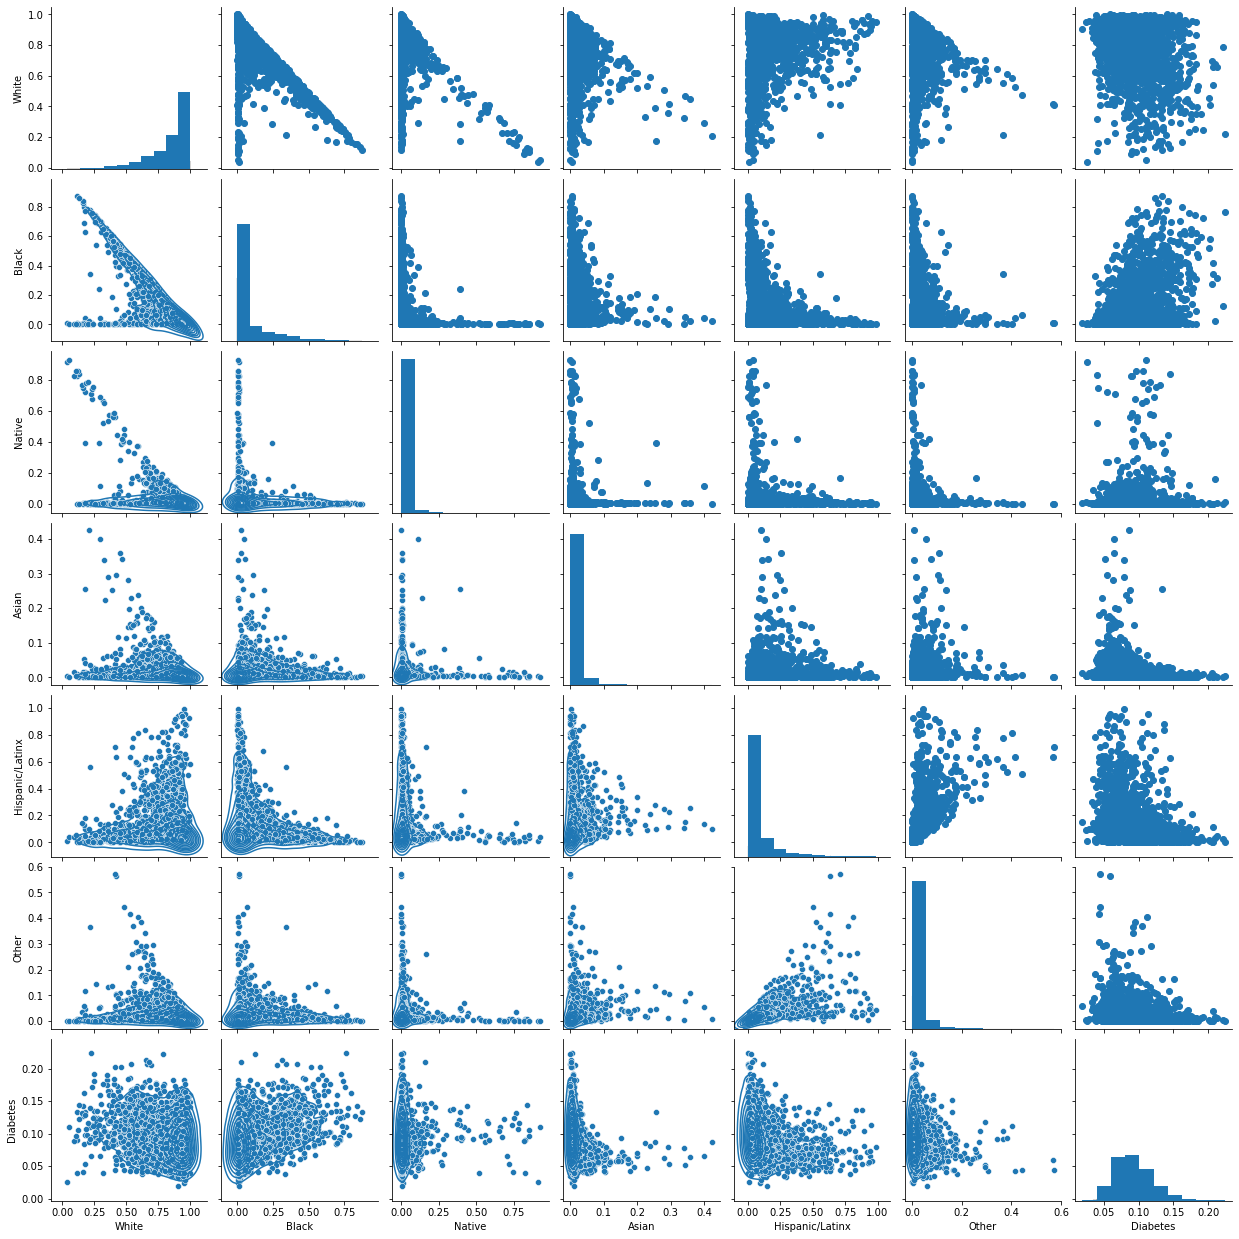

In [55]:
g = sns.pairplot(race_data)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

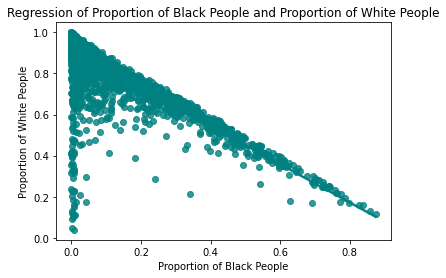

In [56]:
sns.regplot(x='race_total population_one race_black or african american', y='race_total population_one race_white', data=diabetes, color='teal')
plt.title('Regression of Proportion of Black People and Proportion of White People')
plt.xlabel('Proportion of Black People')
plt.ylabel('Proportion of White People');

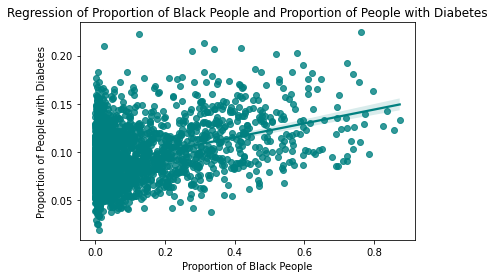

In [57]:
sns.regplot(x='race_total population_one race_black or african american', y='Diabetes_Number', data=diabetes, color='teal')
plt.title('Regression of Proportion of Black People and Proportion of People with Diabetes')
plt.xlabel('Proportion of Black People')
plt.ylabel('Proportion of People with Diabetes');

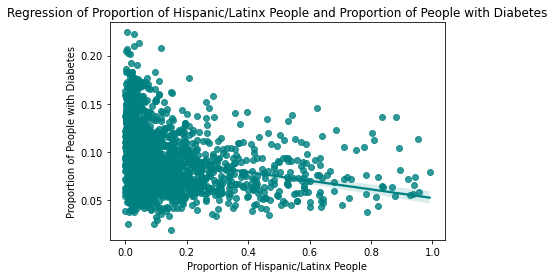

In [58]:
sns.regplot(x='hispanic or latino and race_total population_hispanic or latino (of any race)', y='Diabetes_Number', data=diabetes, color='teal')
plt.title('Regression of Proportion of Hispanic/Latinx People and Proportion of People with Diabetes')
plt.xlabel('Proportion of Hispanic/Latinx People')
plt.ylabel('Proportion of People with Diabetes');

Here, the single-race categories of interest (White, Black, Native American, Asian, Hispanic/Latinx, and Other) are compared with the response variable of interest, diabetes. To avoid multicollinearity, it is important to determine which variables correlate with each, where therefore we must decide to include one and remove the other. We see that White and Black proportions correlate well with each other, hence we decide to remove the White proportion variable, and also because the Black proportion variable captures a more normal distribution which is assumed for the linear model. White and Native are also correlated strongly together, as are White and Asian & White and Other. However, the Hispanic/Latinx population is not correlated strongly with either the White or Black proportion variables, hence keeping it might be important. Instead of using all the race proportion variables, we choose to use proportion Black and proportion Hispanic/Latinx to account for ethno-racial categories in determining the proportion of the population that has diabetes.

### Obesity/ Physical activity/Geography (Flávia)

Our analysis focused on the relationships of Diabetes level with (i) Obesity and the (i) inactivity index. We found a positive relationship between these 2 variables with obesity. Also, we analyzed how obesity levels are distributed among US states. 

Obesity

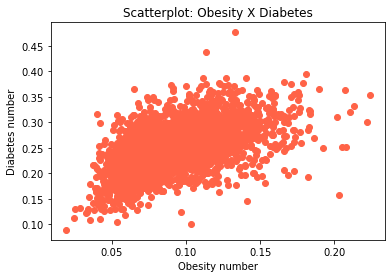

In [59]:
plt.scatter("Diabetes_Number","Obesity_Number", data= diabetes, color='tomato')
plt.yticks

plt.title('Scatterplot: Obesity X Diabetes')
plt.xlabel('Obesity number')
plt.ylabel('Diabetes number')
plt.show()

Inactivity 

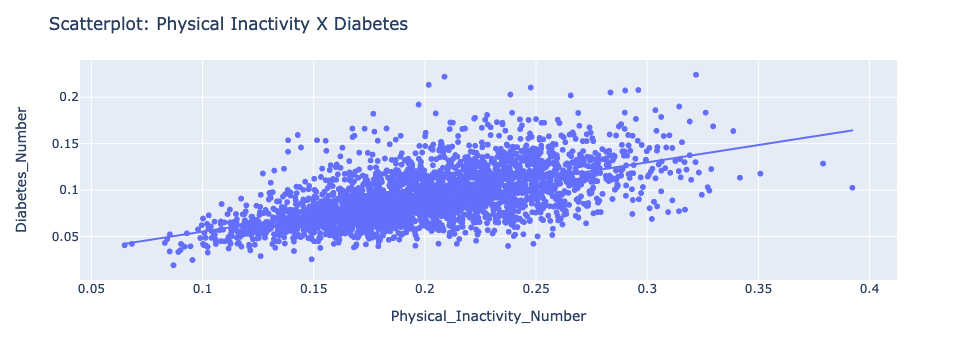

In [60]:
import plotly.express as px

df = px.data.tips()
fig = px.scatter(diabetes, x="Physical_Inactivity_Number", y="Diabetes_Number", trendline="ols",size_max=60)

fig.update_layout(
    height=300,width=500,
    title_text='Scatterplot: Physical Inactivity X Diabetes'
)

fig.show()

Geographies

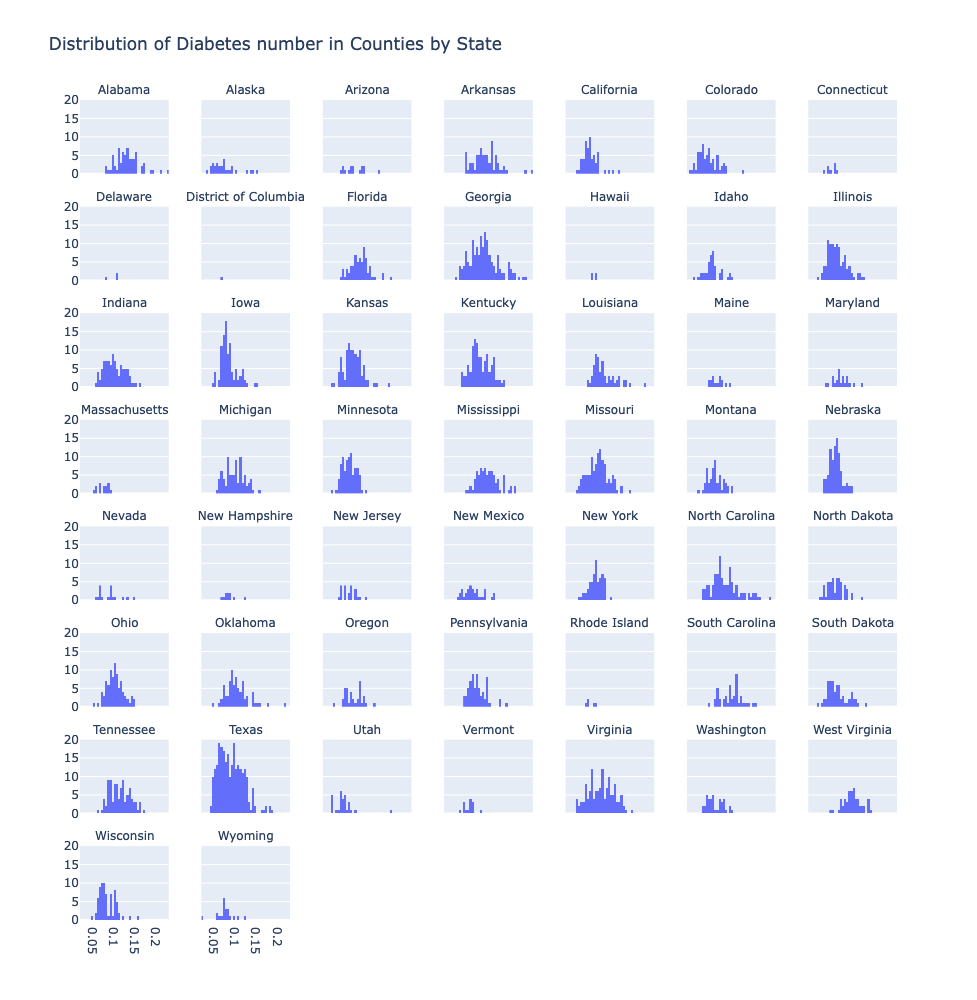

In [61]:

fig = px.histogram(diabetes, x='Diabetes_Number', 
    facet_col='State', facet_col_wrap=7,
              facet_row_spacing=0.04, 
              facet_col_spacing=0.04, 
              height=1000, width=1200,
              title="Distribution of Diabetes number in Counties by State")
 
fig.update_yaxes(title='')
fig.update_xaxes(title='')



for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[1]

fig.show()

The histograms above show the prevalence of diabetes in different counties for every US state. Texas and Georgia,for example,
stand out due to the high levels of diabetes in many of their counties. On the other hand, states like Vermont and Delaware 
show very low diabetes levels in most of their counties. These patterns should be very related to socio-economic status and
racial disparities, as high diabetes rates are more prevalent in states in the northeast and partially in the mid-west,
where average incomes are lower. Considering this trend, we will include a dummy variable for observations that are in the south/mid-western part of the country.

### Age (Abiola)

Our analysis of the age-related variables focus on identifying the relevant age categories.

In [114]:
age_young_data = diabetes[['sex and age_total population_under 5 years',
         'sex and age_total population_5 to 9 years',
         'sex and age_total population_10 to 14 years','sex and age_total population_15 to 19 years',
                     'sex and age_total population_20 to 24 years','sex and age_total population_25 to 34 years','Diabetes_Number']].rename(columns = {'sex and age_total population_under 5 years': '5 and under',
         'sex and age_total population_5 to 9 years': '5-9 years',
         'sex and age_total population_10 to 14 years':'10-14 years' ,'sex and age_total population_15 to 19 years':'15-19 years',
                     'sex and age_total population_20 to 24 years':'20-24 years','sex and age_total population_25 to 34 years': '25-34 years'
                     ,'Diabetes_Number':'Diabetes'})

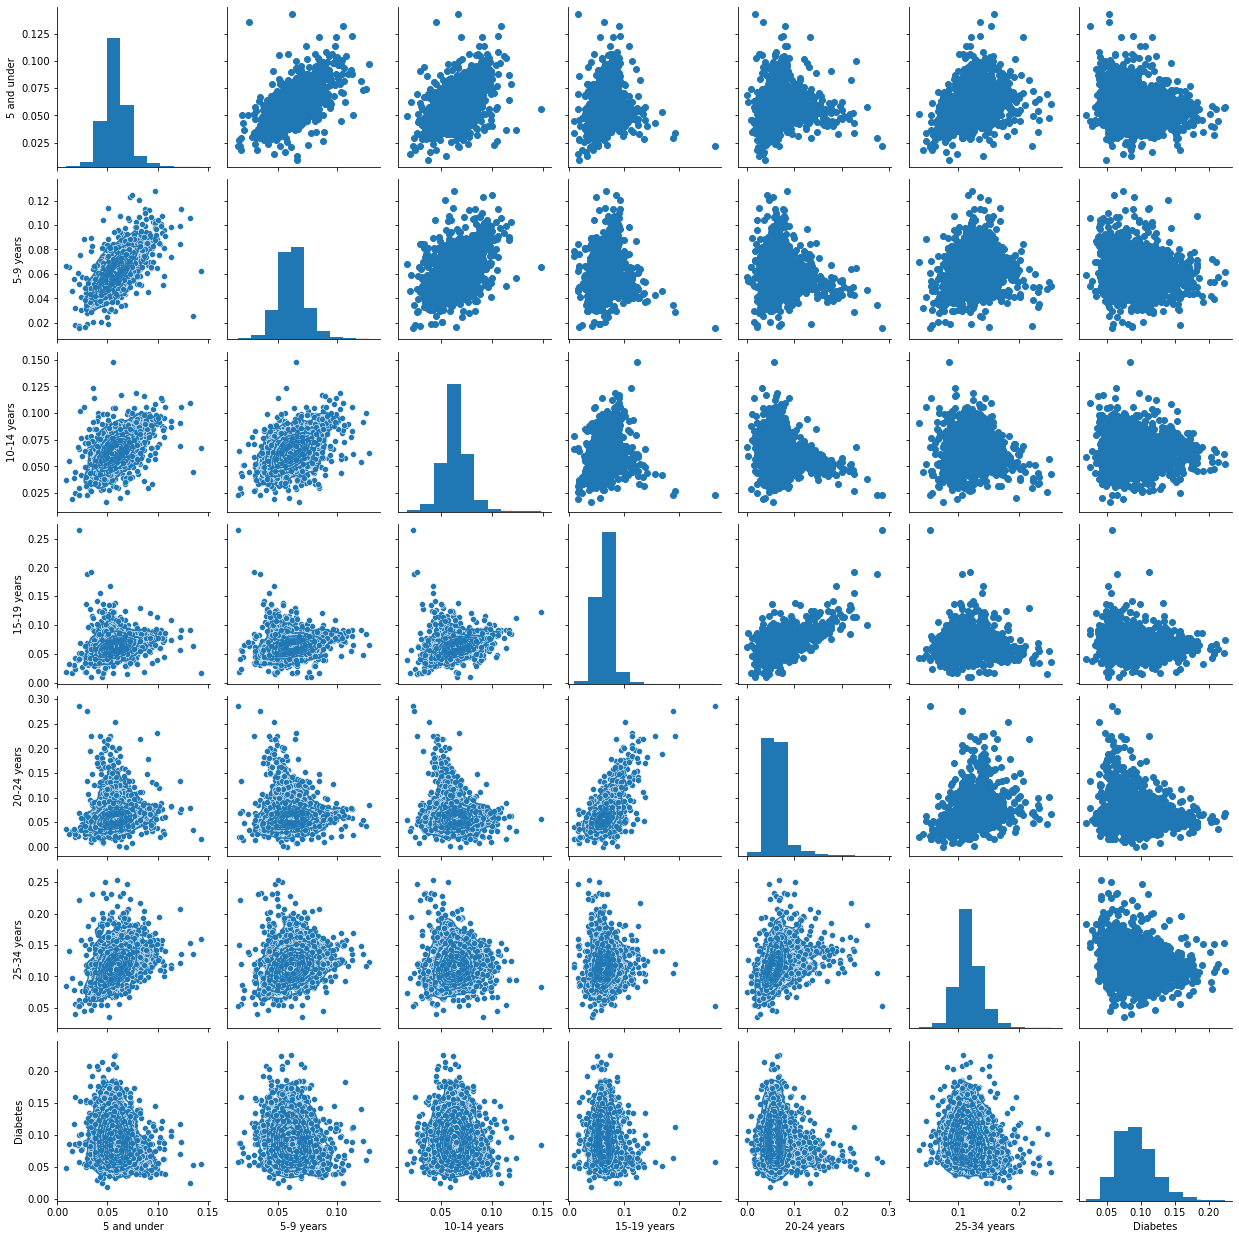

In [115]:
g = sns.pairplot(age_young_data)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

In [116]:
age_old_data = diabetes[['sex and age_total population_45 to 54 years',
                     'sex and age_total population_55 to 59 years','sex and age_total population_60 to 64 years',
                     'sex and age_total population_65 to 74 years','sex and age_total population_75 to 84 years',
                     'sex and age_total population_85 years and over','Diabetes_Number']].rename(columns = {
                     'sex and age_total population_35 to 44 years':'35-44 years', 'sex and age_total population_45 to 54 years':'45-54 years',
                     'sex and age_total population_55 to 59 years':'55-59 years','sex and age_total population_60 to 64 years':'60-64 years',
                     'sex and age_total population_65 to 74 years':'65-74 years','sex and age_total population_75 to 84 years':'75-84 years',
                     'sex and age_total population_85 years and over':'85 years or more','Diabetes_Number':'Diabetes'})

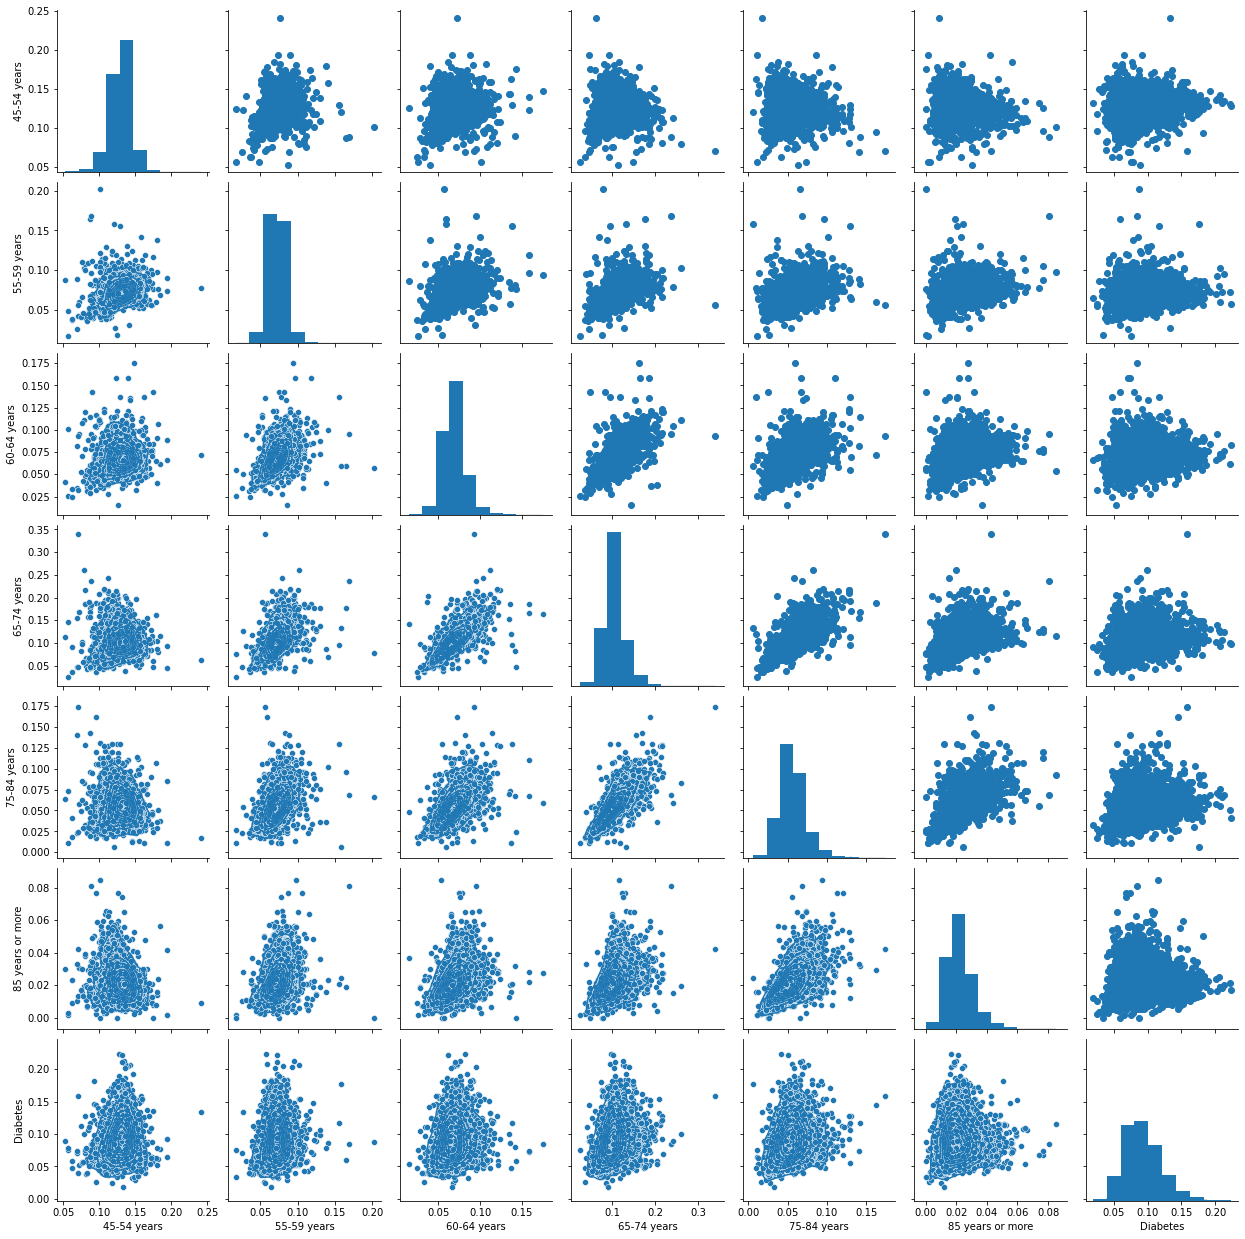

In [117]:
g = sns.pairplot(age_old_data)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

Here, we focus on the age categories and compare them with the variable of interest, diabetes. We again focus on multicollinearity here. For the young-age categories seen in the first plot, the 5 and under category correlates with the 5-9, 10-15, 15-19, and 25-34 categories, hence we decide to keep the 5-9 category and remove the others since this variable captures a normal distribution. The 20-24 age category only correlates with the 15-19 category, but since we are removing that one, we can keep the 20-24 category as well. As for the older-age categories in the second plot, there is a lot of correlation between the categories directly preceding each category. For example, the 60-64 category correlates with the 65-74 category. A decision here is made to remove the two in-between categories, which include the 55-59 and 65-74 categories, but keep the rest. Instead of all the age proportion variables, we choose to keep the 5-9, 20-24, 45-54, 60-64, 75-84, and the 85 and up categories.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [264]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["State"],  
                               drop_first = False) # only create 49 dummies by dropping first in category

# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 


,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [265]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(['Diabetes_Number'], axis=1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [267]:
from sklearn import preprocessing

X = preprocessing.scale(X)

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [268]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

And finally, let's split our data:

In [269]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8, test_size=0.2)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [270]:
#SAME PROCESS CONSIDERING OTHER PREDICTORS (SELECTED VARIABLES)

# Creating two datasets
diabetes_selected = diabetes[['race_total population_one race_black or african american',
                              'hispanic or latino and race_total population_hispanic or latino (of any race)',
                              'State', 'Obesity_Number', 'Physical_Inactivity_Number', 'Diabetes_Number',
                             'total housing units',
                              'citizen -  voting age population_citizen -  18 and over population',
                              'sex and age_total population_female',
                              'sex and age_total population_25 to 34 years',
                              'sex and age_total population_45 to 54 years']]
 


In [271]:
# Creating dummies for South/Midwest states   
diabetes_selected['Region'] = np.where((diabetes_selected['State'] == "Illinois")|(diabetes_selected['State'] == "Indiana")|
                                      (diabetes_selected['State'] == "Iowa")|(diabetes_selected['State'] == "Kansas")|
                                      (diabetes_selected['State'] == "Michigan")|(diabetes_selected['State'] == "Minnesota")|
                                      (diabetes_selected['State'] == "Missouri")|(diabetes_selected['State'] == "Nebraska")|
                                      (diabetes_selected['State'] == "North Dakota")|(diabetes_selected['State'] == "Ohio")|
                                      (diabetes_selected['State'] == "South Dakota")|(diabetes_selected['State'] == "Wisconsin")|
                                      (diabetes_selected['State'] == "Alabama")|(diabetes_selected['State'] == "Arkansas")|
                                      (diabetes_selected['State'] == "Delaware")|(diabetes_selected['State'] == "District of Columbia")|
                                      (diabetes_selected['State'] == "Florida")|(diabetes_selected['State'] == "Georgia")|
                                      (diabetes_selected['State'] == "Kentucky")|(diabetes_selected['State'] == "Louisiana")|
                                      (diabetes_selected['State'] == "Maryland")|(diabetes_selected['State'] == "Mississippi")|
                                      (diabetes_selected['State'] == "North Carolina")|(diabetes_selected['State'] == "Oklahoma")|
                                      (diabetes_selected['State'] == "South Carolina")|(diabetes_selected['State'] == "Tennessee")|
                                      (diabetes_selected['State'] == "Texas")|(diabetes_selected['State'] == "Virginia")|
                                      (diabetes_selected['State'] == "West Virginia"),1,0)


/var/folders/2j/q0n5tmtn1rj3s9fvkmm4k9sm0000gn/T/ipykernel_11570/666864094.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
diabetes_selected_clean = pd.get_dummies(diabetes_selected, 
                               columns = ["State"],  
                               drop_first = False) # we decided to create 50 dummies

# look at first 10 rows of new data frame 
diabetes_selected_clean.head(10) 

,race_total population_one race_black or african american,hispanic or latino and race_total population_hispanic or latino (of any race),Obesity_Number,Physical_Inactivity_Number,Diabetes_Number,total housing units,citizen - voting age population_citizen - 18 and over population,sex and age_total population_female,sex and age_total population_25 to 34 years,sex and age_total population_45 to 54 years,Region,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Hawaii,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,0.191395,0.027681,0.244366,0.226902,0.093804,0.422373,0.748261,0.513152,0.127971,0.142264,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.094970,0.044943,0.233255,0.192324,0.080281,0.537920,0.764957,0.513769,0.112087,0.136132,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.475758,0.042898,0.310643,0.210651,0.131875,0.462997,0.775386,0.468738,0.142541,0.133892,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.222755,0.024282,0.290052,0.258667,0.105251,0.406668,0.784481,0.460558,0.136503,0.152661,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.014954,0.091266,0.246804,0.249198,0.108977,0.420193,0.739474,0.506740,0.117721,0.137861,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.762461,0.004927,0.353748,0.321967,0.224208,0.437210,0.792311,0.452956,0.108192,0.127705,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.452185,0.003346,0.349513,0.300974,0.145318,0.500674,0.767041,0.532185,0.121049,0.121199,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.205703,0.036517,0.298580,0.234140,0.127648,0.466403,0.768050,0.519410,0.130471,0.129959,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.393750,0.022704,0.324425,0.220570,0.141518,0.502010,0.781174,0.519393,0.109117,0.137409,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.049008,0.015395,0.300429,0.237342,0.122848,0.639423,0.792635,0.504119,0.097822,0.140873,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [273]:
# X (everything except diabetes, our target)
X_selected = diabetes_selected_clean.drop(['Diabetes_Number'], axis=1)

In [274]:
from sklearn import preprocessing

X_selected = preprocessing.scale(X_selected)

In [275]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X_selected = selector.fit_transform(X_selected)

In [276]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y,
                                                    train_size=0.8, test_size=0.2)

X_selected_train, X_selected_validate, y_selected_train, y_selected_validate = train_test_split(X_selected_train, y_selected_train,
                                                    train_size=0.75, test_size=0.25)

## 4. Train Models

In [277]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2)) 

1) First model: Linear Regression OLS + all variables

In [278]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

In [279]:
# predict the number of riders
lin_pred = lin_model.predict(X_validate)

In [280]:
rmse(lin_pred, y_validate)

0.02160456140699657

2) Second model: Linear Regression OLS + selected variables

In [281]:
# fit the model
lin_model_selected = lin_reg.fit(X_selected_train, y_selected_train)

In [282]:
# predict the number of riders
lin_pred_selected = lin_model_selected.predict(X_selected_validate)

In [283]:
rmse(lin_pred_selected, y_selected_validate)

0.01990502042763688

3) Third model: Ridge + all variables

In [284]:
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)

In [285]:
ridge_pred = ridge_model.predict(X_validate)

In [286]:
rmse(ridge_pred, y_validate)

0.02163452833540395

4) Fourth model: Ridget + selected variables

In [287]:
ridge_model_selected = ridge_reg.fit(X_selected_train, y_train)

In [288]:
ridge_pred_selected = ridge_model_selected.predict(X_selected_validate)

In [289]:
rmse(ridge_pred_selected, y_selected_validate)

0.02877388651794239

5) Fith model: LASSO + all variables

In [290]:
lasso_reg = Lasso(max_iter=10000)  

lasso_model = lasso_reg.fit(X_train, y_train)

In [291]:
lasso_pred = lasso_model.predict(X_validate)

In [292]:
rmse(lasso_pred, y_validate)

0.028410406174158482

6) Sixth model: LASSO + selected variables

In [293]:
lasso_model_selected = lasso_reg.fit(X_selected_train, y_train)

In [294]:
lasso_pred_selected = lasso_model_selected.predict(X_selected_validate)


In [295]:
rmse(lasso_pred_selected, y_selected_validate)

0.027260532528713213

## 5. Validate and Refine Models

In [ ]:
# use X_validation and y_validation data sets to evaluate and refine your models

All six models have similar accuracy, between 0.020 and 0.030 RMSE.
However, the two models with the smallest mean squared errors are: the first model (Linear Regression OLS + all variables) and the third model(Ridge + all variables).

In [372]:
X = diabetes.drop(['Diabetes_Number'], axis=1)
lin_model_data = pd.DataFrame([lin_model.coef_, X.columns]).T
lin_model_data.columns = ['Coefficient', 'Feature']

In [373]:
lin_model_data['Coefficient'] = lin_model_data['Coefficient'][1:61]
lin_model_data['Feature'] = list(range(1, 89))
lin_model_data['Feature'] = [str(x) for x in lin_model_data['Feature']]

In [374]:
ridge_model_data = pd.DataFrame([ridge_model.coef_, X.columns]).T
ridge_model_data.columns = ['Coefficient', 'Feature']

In [375]:
ridge_model_data['Coefficient'] = ridge_model_data['Coefficient'][1:61]
ridge_model_data['Feature'] = list(range(1, 89))
ridge_model_data['Feature'] = [str(x) for x in ridge_model_data['Feature']]

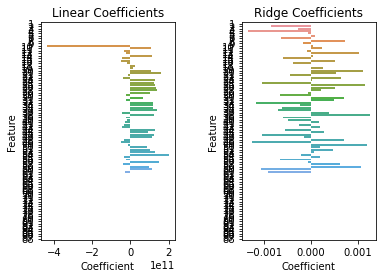

In [376]:
figure = plt.figure()
figure.subplots_adjust(wspace = .5, hspace=.5)
figure.add_subplot(1, 2, 1)
sns.barplot(x="Coefficient", y="Feature", data=lin_model_data).set_title("Linear Coefficients")
figure.add_subplot(1, 2, 2)
sns.barplot(x="Coefficient", y="Feature", data=ridge_model_data).set_title("Ridge Coefficients")
plt.show()  

The bar plots compare the coefficients for the linear and Ridge models. As one can see, the coefficients on the Ridge regression are much smaller than for the linear one due to the shrinkage process.  The regularization performed by Ridge made some of the coefficients to become very close to zero, but not zero. In this context, the Ridge model helps us in performing feature selection. We decided to eliminate the features with the smaller coefficients that were very close to 0 but not exactly 0.

In [400]:
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["State"],  
                               drop_first = False)
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1)
X = diabetes_clean.drop(['Diabetes_Number'], axis=1)
lin_model_data = pd.DataFrame([lin_model.coef_, X.columns]).T

In [401]:
X_final_lin = diabetes[list(lin_model_data[1:61][1])]

In [402]:
ridge_model_data = pd.DataFrame([ridge_model.coef_, X.columns]).T

In [403]:
X_final_ridge = diabetes[list(ridge_model_data[1:61][1])]

In [404]:
X_final_lin = preprocessing.scale(X_final_lin)
selector = feature_selection.VarianceThreshold(0)
X_final_lin = selector.fit_transform(X_final_lin)
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final_lin, y,
                                                    train_size=0.8, test_size=0.2)

X_final_train, X_final_validate, y_final_train, y_final_validate = train_test_split(X_final_train, y_final_train,
                                                    train_size=0.75, test_size=0.25)

In [405]:
lin_model_final = lin_reg.fit(X_final_train, y_final_train)
lin_pred_final = lin_model_final.predict(X_final_validate)
rmse(lin_pred_final, y_final_validate)

0.020567109876893582

In [407]:
ridge_model_final = ridge_reg.fit(X_final_train, y_final_train)
ridge_pred_final = ridge_model_final.predict(X_final_validate)
rmse(ridge_pred_final, y_final_validate)

0.020520791309772052

For the linear regression OLS and Ridge models, with removed variables, the RMSE improved slightly for both models. After running all of the tests, we've declared the Ridge model with removed variables to be the best model.

The validation set can be used to evaluate the performance of the model for different values of hyperparameters. Besides tuning model hyperparameters, the validation set is a way for the researcher to evaluate the model fit in a dataset that is not the “final” one (test set). Therefore, using the validation set, and not only the test set, contributes to reduce bias of the final model.

### Cross-Validation

#### With K=3 Folds

In [413]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_final_train, y_final_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_final_validate)

print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_final_validate, y_final_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_final_validate))

Best CV R^2: 0.44376158476600897
Validation R^2: 0.4954600216965872
Validation RMSE 0.020504330297895886


#### With K=5 Folds

In [414]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=5)
ridge_grid_reg.fit(X_final_train, y_final_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_final_validate)

print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_final_validate, y_final_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_final_validate))

Best CV R^2: 0.4508349815789458
Validation R^2: 0.49450314749956015
Validation RMSE 0.020523764606120203


#### With K=9 Folds

In [415]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=9)
ridge_grid_reg.fit(X_final_train, y_final_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_final_validate)

print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_final_validate, y_final_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_final_validate))

Best CV R^2: 0.450319013545957
Validation R^2: 0.49450314749956015
Validation RMSE 0.020523764606120203


The choice of k seems to matter: in terms of best CV rˆ2 the K=5 folds model was the best, for validation rˆ2 the K=3 folds model was the best, and for validation RMSE the K=3 folds model was the best. The K=3 fold model was actually better in terms of RMSE than our train/validation/test split approach, but ever so slightly.

## 6. Discussion Questions

6.1
The bias-variance tradeoff refers to finding the "correct" balance between bias and variance, in order to achieve the most accurate predictions, since it is impossible to achieve low-variance and low bias at the same time. In general, high-variance model are good representations of the sample set, but not very generalizable.
High bias models, on their turn, lead to simpler models that do not predict well. In our efforts to infer just enough information from our sample so that our model will describe the out-of-sample conditions accurately, we make a tradeoff between minimizing bias and variance in the model that describes the training data. In machine learning problems like this one, we are willing to trade some bias in the model that describes the sample, so that we can capture the overall trend in the data and not the specific patterns/idiosyncrasies of the trainig data.

6.2
Overfitting occurs when a statistical model does not make accurate predictions on testing data. A model built/trained on a large sample data, learns from the noise and idiosyncrasies of that training dataset. Therefore, the resulting model is too complex and, when applied to the test data results in high variance.
This issue may generate machine learning models that do not perform well in terms of prediction.

Some strategies to address overfitting are: (i) increase the training data; (ii) use Ridge regression; (iii)
use Lasso regression. The two last strategies are methods that skrink coefficient estimates toward zero, penalizing or removing extra features that do not reduce bias.